## Logn term, Short term

## 0815/0910 full


train: 08월 학습, 9월 10일간 test

## import

In [1]:
import pandas as pd
import numpy as np
import json
import urllib
import time

In [46]:
# 일반적인 모듈 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx 
from tqdm import tqdm 

# 파이토치 관련 
import torch
import torch.nn.functional as F

# PyG 관련 
from torch_geometric.data import Data ## Data: 그래프자료형을 만드는 클래스

# STGCN 관련 
import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split 

In [47]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [53]:
from mysolar2 import NormalSolarDatasetLoader

In [54]:
loader = NormalSolarDatasetLoader()
dataset = loader.get_dataset(lags=4)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.756)

In [55]:
31/(31+10)

0.7560975609756098

In [56]:
print(np.array(train_dataset.targets).shape)
print(np.array(test_dataset.targets).shape)

(486, 44)
(158, 44)


## Learn

In [57]:
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

for epoch in tqdm(range(50)):
    for t, snapshot in enumerate(train_dataset):
        yt_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((yt_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


In [58]:
import pickle 
with open('./model4/normal_stgcn1_lag4_new.pickle','wb') as fw:
    pickle.dump(model, fw)

In [59]:
import pickle 
with open('./model4/normal_stgcn1_lag4_new.pickle', 'rb') as f: 
    model = pickle.load(f)

In [60]:
model

RecurrentGCN(
  (recurrent): GConvGRU(
    (conv_x_z): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_z): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_r): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_r): ChebConv(32, 32, K=2, normalization=sym)
    (conv_x_h): ChebConv(4, 32, K=2, normalization=sym)
    (conv_h_h): ChebConv(32, 32, K=2, normalization=sym)
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

## 모델평가

`-` train

- MSE: 0.2102 (before normalize)

In [61]:
model.eval()
cost = 0
for time, snapshot in enumerate(train_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.2122


`-` test

- MSE: 0.1899 (before normalize)

In [62]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.1124


## Visualization

In [63]:
url = 'https://raw.githubusercontent.com/pinkocto/noteda/main/posts/SOLAR/data3/stgcn_data1.json'

In [64]:
data_dict = json.loads(urllib.request.urlopen(url).read())
V = list(data_dict['node_ids'].keys())
f = np.array(data_dict["FX"])

In [65]:
yhat_train = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in train_dataset]).detach().numpy()
yhat_test = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in test_dataset]).detach().numpy()

In [66]:
f.shape

(648, 44)

In [67]:
yhat_test.shape[0] +  yhat_train.shape[0]

644

In [68]:
yhat_test.shape, yhat_train.shape

((158, 44, 1), (486, 44, 1))

In [69]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

### train

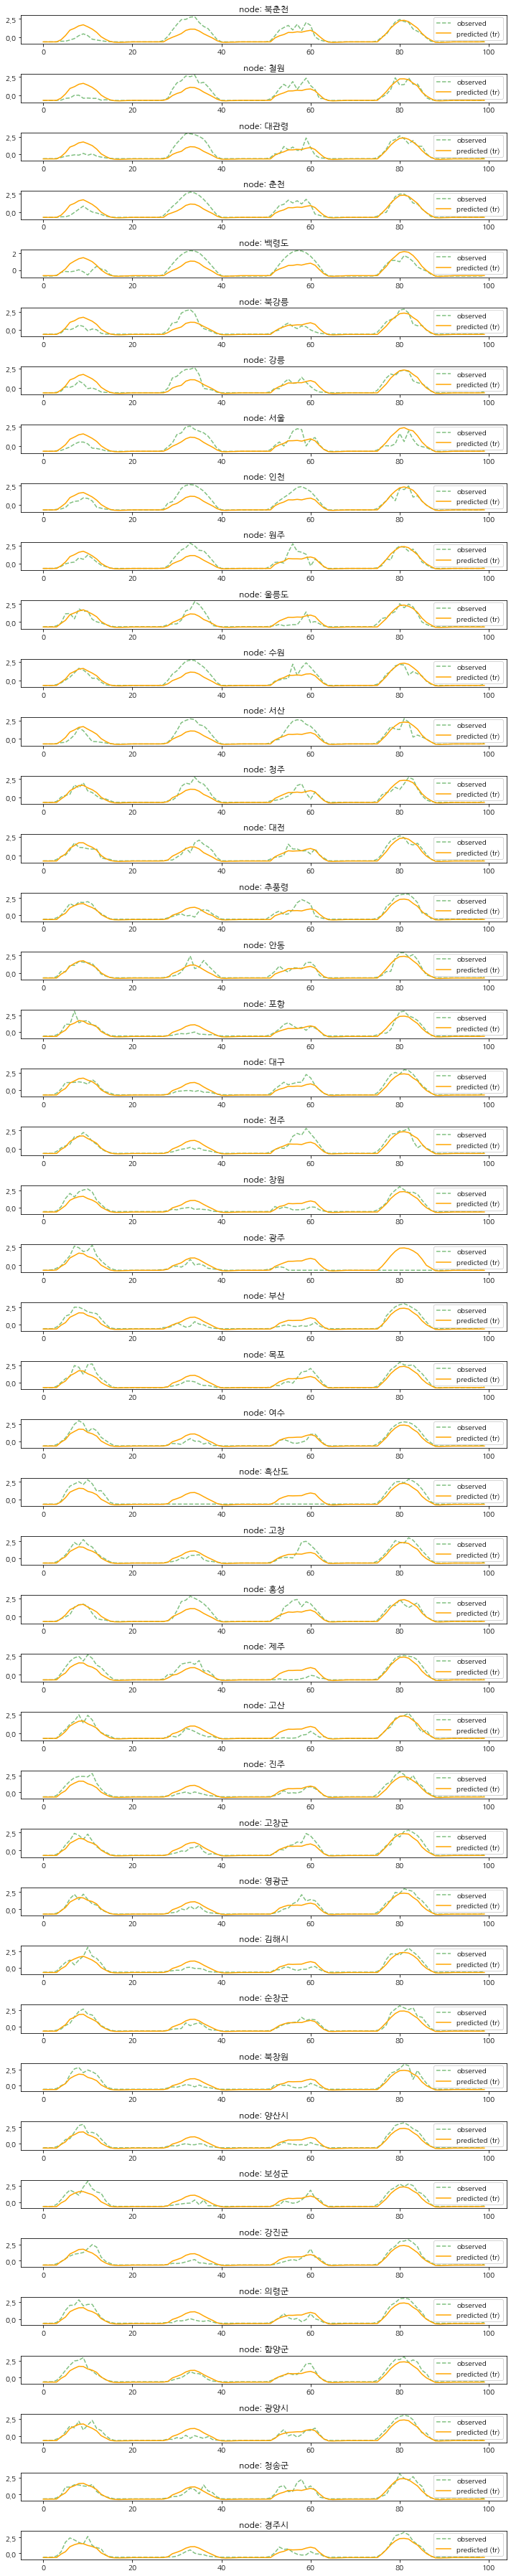

In [70]:
fig,ax = plt.subplots(44,1,figsize=(10,50))
lag= 0 
T = 100 
for k in range(44):
    ax[k].plot(np.array(train_dataset.targets)[lag:(lag+T),k],'--',alpha=0.5,label='observed', color='green')
    ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_train[:T,k],label='predicted (tr)', color = 'orange')
#    ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
fig.tight_layout()

# plt.savefig('stgcn-ver2-lag4-vis.png')

In [71]:
np.array(dataset.features).shape

(644, 44, 4)

In [139]:
np.array(dataset.targets).shape

(2350, 44)

In [152]:
np.array(train_dataset.targets).shape

(1645, 44)

In [153]:
np.array(test_dataset.targets).shape

(705, 44)

### test

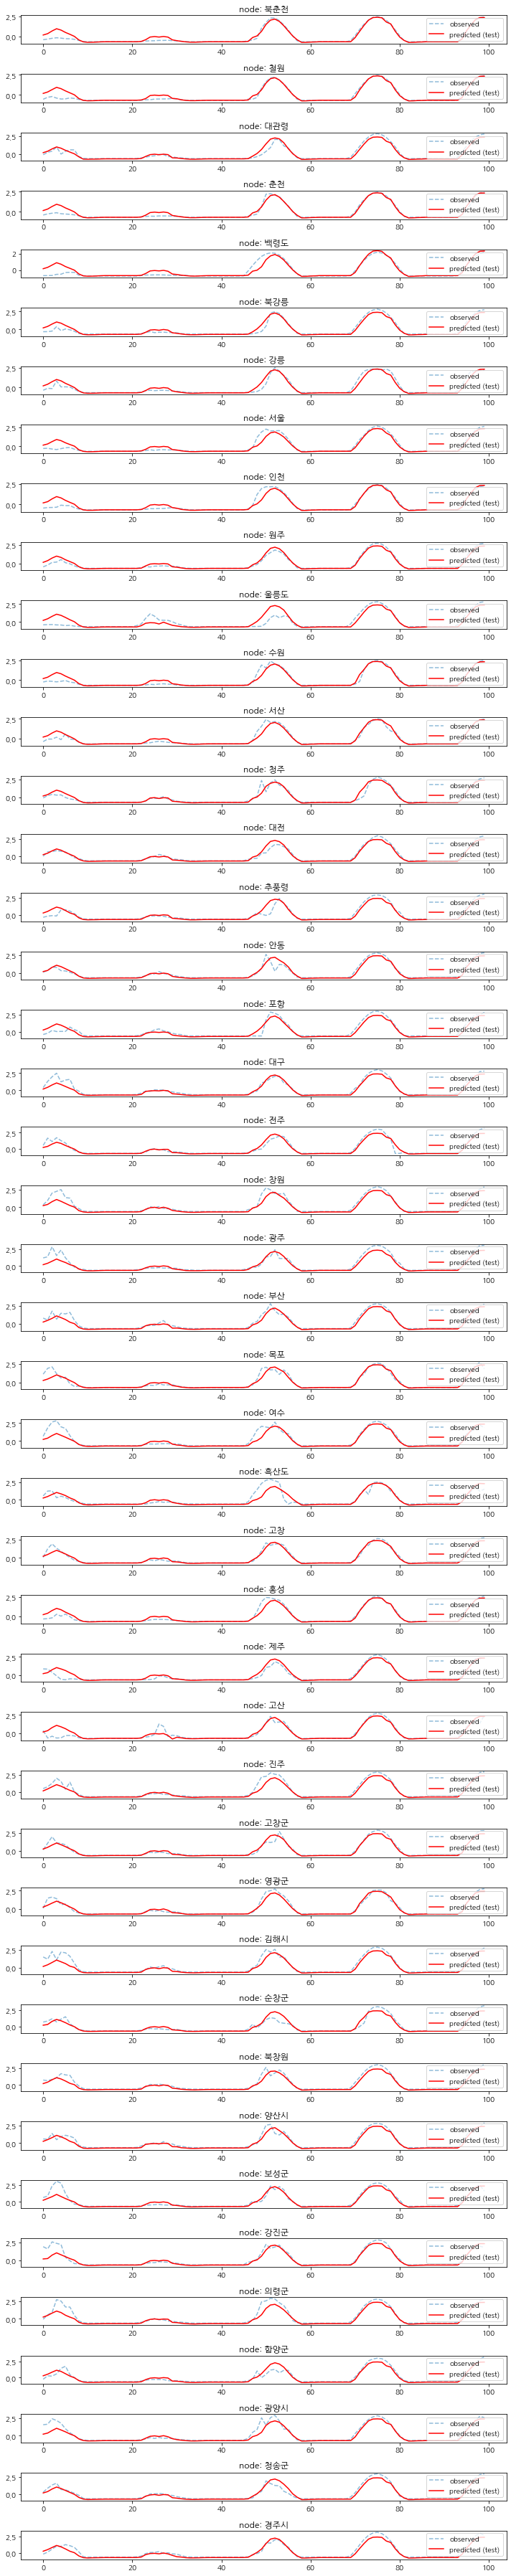

In [72]:
fig,ax = plt.subplots(44,1,figsize=(10,50))
lag= 0
T = 100 
for k in range(44):
    ax[k].plot(np.array(test_dataset.targets)[lag:(lag+T),k],'--',alpha=0.5,label='observed')
    ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_test[:T,k],label='predicted (test)', color='red')
#    ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
fig.tight_layout()

# plt.savefig('stgcn-ver2-lag4-vis.png')